In [94]:
def find_max_quintile (precip, n):
    # Difference with this to Huff curve function, is it doesnt normalise
    cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(precip)
    dimensionless_cumulative_rainfall, dimensionless_times =  create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
    interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall,n)
    interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)
    max_quintile_profile = find_part_with_most_rain(interpolated_n_incremental_rainfall, n)
    
    return max_quintile_profile 


def create_cumulative_event(rainfall, interval=0.5):
    
    # Calculate cumulative rainfall
    cumulative_rainfall = np.cumsum(rainfall)
    cumulative_rainfall = [0] + cumulative_rainfall
    
    # Generate corresponding time points
    time_points = np.arange(0, len(rainfall) + 1) * interval
    
    return  [0] + cumulative_rainfall.tolist(), time_points.tolist()


def create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times):
    # Normalize the cumulative rainfall by the total event depth
    total_event_depth = cumulative_rainfall[-1]
    normalized_cumulative_rainfall = np.array(cumulative_rainfall) / total_event_depth

    # Normalize the cumulative rainfall times by the total event time
    total_event_time = cumulative_rainfall_times[-1]
    normalized_cumulative_rainfall_times = np.array(cumulative_rainfall_times) / total_event_time
    
    return normalized_cumulative_rainfall, normalized_cumulative_rainfall_times

def interpolate_rainfall(rainfall, bin_number):
    if rainfall is None or len(rainfall) < 2:
        return None

    # Define target points for bin_number bins
    target_points = np.linspace(0, 1, bin_number+1)
    
    # Create interpolation function based on existing data points
    rainfall_times = np.array(range(0, len(rainfall)))

    # Normalize time from 0 to 1
    normalized_time = (rainfall_times - rainfall_times[0]) / (rainfall_times[-1] - rainfall_times[0])
    interpolation_func = interp1d(normalized_time, rainfall, kind='linear', fill_value="extrapolate")
    
    # Interpolate values at target points
    interpolated_values = interpolation_func(target_points)
    
    return interpolated_values, target_points

def create_incremental_event(cumulative_rainfall):
    if cumulative_rainfall is None :
        return None
    raw_rainfall = np.diff(cumulative_rainfall, prepend=0)
    return raw_rainfall# [1:]

def find_part_with_most_rain(array, n, plot=False, ax=False):

    # Compute differences
    # Split the array into 5 equal parts
    splits = np.array_split(array, n)

    max_array_rainfall = 0
    max_array_num = None

    total_precipitations = []  # To store total precipitation for each split
    split_ranges = []  # To store start and end indices for each split

    # Calculate total precipitation for each split
    split_start = 0
    for split in splits:
        total_precipitation = split.sum()
        total_precipitations.append(total_precipitation)
        split_end = split_start + len(split)
        split_ranges.append((split_start, split_end))
        if total_precipitation > max_array_rainfall:
            max_array_num = len(total_precipitations)
            max_array_rainfall = total_precipitation
        split_start = split_end

    colors = ['lightblue'] * n  # Default color for all splits
    highlight_color = 'yellow'  # Color for the split with the most rainfall

    if plot:
        # Plot the array
        ax.plot(range(1, len(array) + 1), array, label='Precipitation', marker='o')

        # Add vertical lines and shading for each split segment
        for i, (start_index, end_index) in enumerate(split_ranges):
            color = highlight_color if (i + 1) == max_array_num else colors[i]

            # Add vertical lines at the start and end of each split
            ax.axvline(x=start_index + 1, color=color, linestyle='--', label=f'Split {i+1} Start' if i == 0 or (i + 1) == max_array_num else "")
            ax.axvline(x=end_index, color=color, linestyle='--', label=f'Split {i+1} End' if i == 0 or (i + 1) == max_array_num else "")

            # Shade the region for the split
            ax.fill_between(range(start_index + 1, end_index + 1), array[start_index:end_index], color=color, alpha=0.3)

            # Add the total precipitation value behind the shading
            ax.text((start_index + end_index) / 2+0.5, max(array) * 0.05,  # Adjust y-position if needed
                    f'{total_precipitations[i]:.2f}',
                    ha='center', va='center', fontsize=10, color='black', weight='bold', zorder=1)

        ax.set_title(f'Precipitation Values with Splits Marked. Max at {max_array_num}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Precipitation')

    return max_array_num   

import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

## Get some sample data

In [28]:
home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

In [69]:
time_period='Future'
gauge_num=1
em = 'bb189'
indy_events_fp = home_dir2 + f"ProcessedData/IndependentEvents/UKCP18_30mins/{time_period}/{em}/{gauge_num}/WholeYear/EventSet/"

files = [f for f in os.listdir(indy_events_fp) if f.endswith('.csv')]
files = np.sort(files)
sample_short = pd.read_csv(indy_events_fp + files[20])
sample_long = pd.read_csv(indy_events_fp + files[70])

In [70]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [60]:
def find_and_plot(sample):
    # ECDF (Empirical Cumulative Distribution Function) computes the cumulative probability for each point in the sample.
    # The ECDF for a given value in the sample tells us what percentage of the sample is less than or equal to that value.
    sample_edf = ECDF(sample)

    # Takes the unique values from the sample and sorts them.
    # These are the points where the ECDF will have "jumps" because the ECDF is a step function.
    slope_changes = sorted(set(sample))

    # For each unique value (slope change), we compute the ECDF value.
    # These ECDF values represent the cumulative probability at each unique point in the sample.
    sample_edf_values_at_slope_changes = [sample_edf(item) for item in slope_changes]

    # Invert the ECDF using linear interpolation.
    # This interpolation creates a smooth function that lets us input a cumulative probability and get the corresponding sample value.
    # This "flips" the ECDF so we can find what data value corresponds to any cumulative probability.
    inverted_edf = interp1d(sample_edf_values_at_slope_changes, slope_changes)

    # Create a range of cumulative probabilities (percentiles) from 10% to 100% to plot against the sample values.
    # The inverted ECDF will map these probabilities back to sample values.
    x = np.linspace(0.1, 1, 12)
    y = inverted_edf(x)

    # Plot the inverted ECDF.
    # This line represents how the cumulative probability maps back to sample values (smoothed through interpolation).
    plt.plot(x, y, 'ro', x, y, 'b-')

    # Set axis labels to clarify that we're plotting cumulative probability (percentiles) on the x-axis
    # and the corresponding sample values on the y-axis.
    plt.xlabel("Cumulative Probability")  # Label for the x-axis
    plt.ylabel("Sample Value")  # Label for the y-axis
    plt.title("Inverted ECDF: Sample Value vs. Cumulative Probability")

    # Display the plot.
    plt.show()

    # Print the value that corresponds to the 97.5th percentile in the inverted ECDF.
    # This gives us the data value at the 97.5% cumulative probability.
    print('97.5 percentile:', inverted_edf(0.975))

    # NOTE: If you want to plot the original data points on this graph as well, 
    # you can uncomment the

def plot_ecdf(sample):
    # Compute the ECDF for the sample
    sample_edf = ECDF(sample)
    
    # Sort the sample values to plot them in order
    sorted_sample = sorted(sample)
    
    # Plot the ECDF as a step function
    plt.step(sample_edf(sorted_sample), sorted_sample, where='post', color='blue', label='ECDF')

    # Add labels and title
    plt.xlabel('Sample Value')  # x-axis shows the data points (sample values)
    plt.ylabel('Cumulative Probability')  # y-axis shows the cumulative probability (ECDF)
    plt.title('Empirical CDF (ECDF) of the Sample')

    # Show legend and plot
    plt.legend()
    plt.grid(True)
    plt.show()

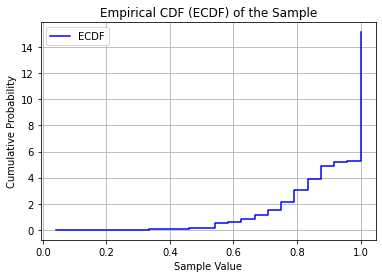

In [64]:
# Example sample data
plot_ecdf(sample_short['precipitation (mm)'])

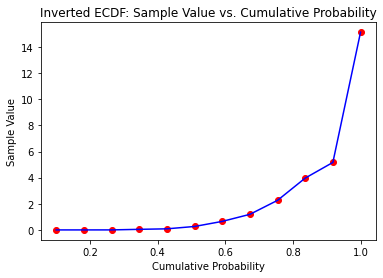

97.5 percentile: 9.204185619999988


In [61]:
find_and_plot(sample_short['precipitation (mm)'])

In [95]:
n = 6
sample = [1, 4, 2, 6, 5, 5, 3, 3, 5, 7]
cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(sample)
dimensionless_cumulative_rainfall, dimensionless_times =  create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall,n)
interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)
max_quintile_profile = find_part_with_most_rain(interpolated_n_incremental_rainfall, n)

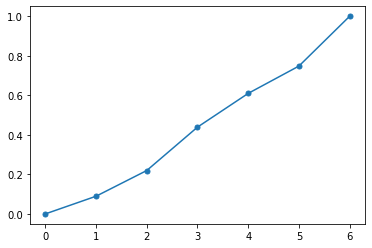

In [76]:
plt.plot(interpolated_n_cumulative_rainfall, marker='.', markersize=10)

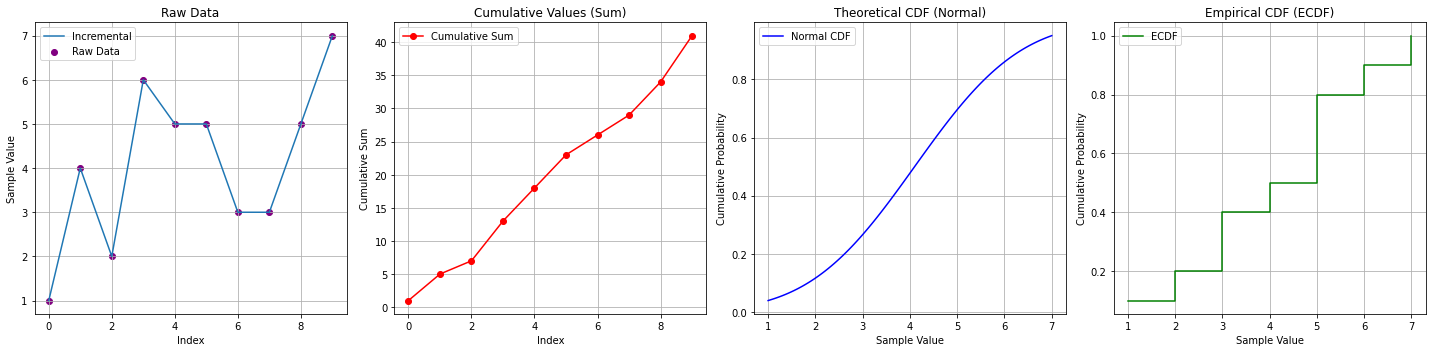

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF

# Sample data
sample = [1, 4, 2, 6, 5, 5, 3, 3, 5, 7]

# Create a figure with 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# 1. Raw Data Plot
axs[0].plot(sample, label = 'Incremental')
axs[0].scatter(range(len(sample)), sample, color='purple', label='Raw Data')
axs[0].set_title('Raw Data')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Sample Value')
axs[0].legend()
axs[0].grid(True)


# 4. Cumulative Values (Cumulative Sum)
cumulative_values = np.cumsum(sample)

axs[1].plot(range(len(sample)), cumulative_values, label='Cumulative Sum', marker='o', color='red')
axs[1].set_title('Cumulative Values (Sum)')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Cumulative Sum')
axs[1].legend()
axs[1].grid(True)


# 2. Theoretical CDF (for comparison, let's assume a normal distribution)
# Fit a normal distribution to the sample for demonstration
mu, std = np.mean(sample), np.std(sample)
x = np.linspace(min(sample), max(sample), 100)
cdf_values = norm.cdf(x, mu, std)

axs[2].plot(x, cdf_values, label='Normal CDF', color='blue')
axs[2].set_title('Theoretical CDF (Normal)')
axs[2].set_xlabel('Sample Value')
axs[2].set_ylabel('Cumulative Probability')
axs[2].legend()
axs[2].grid(True)

# 3. ECDF (Empirical Cumulative Distribution Function)
sample_edf = ECDF(sample)
sorted_sample = sorted(sample)

axs[3].step(sorted_sample, sample_edf(sorted_sample), where='post', label='ECDF', color='green')
axs[3].set_title('Empirical CDF (ECDF)')
axs[3].set_xlabel('Sample Value')
axs[3].set_ylabel('Cumulative Probability')
axs[3].legend()
axs[3].grid(True)


# Show the figure
plt.tight_layout()
plt.show()


In [97]:
n = 5
sample = [1, 4, 2, 6, 5, 5, 3, 3, 5, 7]
cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(sample)
dimensionless_cumulative_rainfall, dimensionless_times =  create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall,n)
interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)
max_quintile_profile = find_part_with_most_rain(interpolated_n_incremental_rainfall, n)

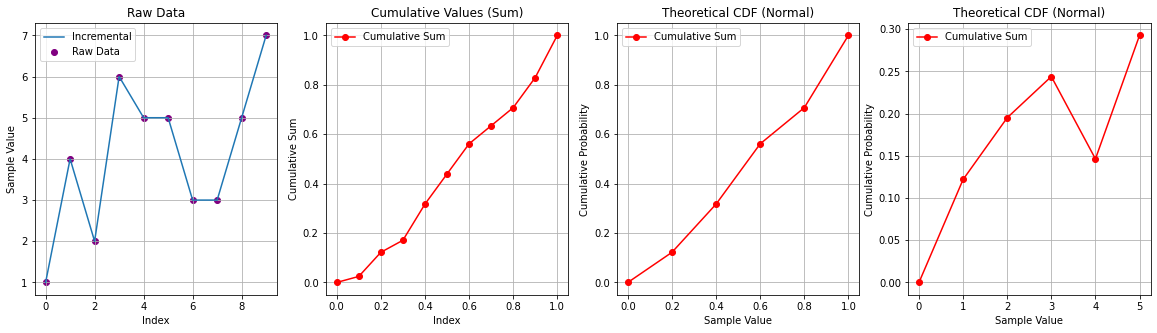

In [98]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# 1. Raw Data Plot
axs[0].plot(sample, label = 'Incremental')
axs[0].scatter(range(len(sample)), sample, color='purple', label='Raw Data')
axs[0].set_title('Raw Data')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Sample Value')
axs[0].legend()
axs[0].grid(True)

# 4. Cumulative Values (Cumulative Sum)
axs[1].plot(dimensionless_times, dimensionless_cumulative_rainfall, label='Cumulative Sum', marker='o', color='red')
axs[1].set_title('Cumulative Values (Sum)')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Cumulative Sum')
axs[1].legend()
axs[1].grid(True)

# 4. Cumulative Values (Cumulative Sum)
axs[2].plot(interpolated_n_times, interpolated_n_cumulative_rainfall, label='Cumulative Sum', marker='o', color='red')
axs[2].set_title('Theoretical CDF (Normal)')
axs[2].set_xlabel('Sample Value')
axs[2].set_ylabel('Cumulative Probability')
axs[2].legend()
axs[2].grid(True)

# 4. Cumulative Values (Cumulative Sum)
axs[3].plot(range(len(interpolated_n_incremental_rainfall)), interpolated_n_incremental_rainfall, label='Cumulative Sum', marker='o', color='red')
axs[3].set_title('Theoretical CDF (Normal)')
axs[3].set_xlabel('Sample Value')
axs[3].set_ylabel('Cumulative Probability')
axs[3].legend()
axs[3].grid(True)



# # 2. Theoretical CDF (for comparison, let's assume a normal distribution)
# # Fit a normal distribution to the sample for demonstration
# mu, std = np.mean(sample), np.std(sample)
# x = np.linspace(min(sample), max(sample), 100)
# cdf_values = norm.cdf(x, mu, std)

# axs[2].plot(x, cdf_values, label='Normal CDF', color='blue')
# axs[2].set_title('Theoretical CDF (Normal)')
# axs[2].set_xlabel('Sample Value')
# axs[2].set_ylabel('Cumulative Probability')
# axs[2].legend()
# axs[2].grid(True)

# # 3. ECDF (Empirical Cumulative Distribution Function)
# sample_edf = ECDF(sample)
# sorted_sample = sorted(sample)

# axs[3].step(sorted_sample, sample_edf(sorted_sample), where='post', label='ECDF', color='green')
# axs[3].set_title('Empirical CDF (ECDF)')
# axs[3].set_xlabel('Sample Value')
# axs[3].set_ylabel('Cumulative Probability')
# axs[3].legend()
# axs[3].grid(True)


# # Show the figure
# plt.tight_layout()
# plt.show()
